<a href="https://colab.research.google.com/github/Nivratti/100-Days-Of-ML-Code/blob/master/face_anti_spoofing_face_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# ls "/content/drive/My Drive/deep_learning/"
ls "/content/drive/My Drive/deep_learning/face-anti-spoofing/face-only/"

dataset/  face-only-dataset.zip


In [0]:
cp "/content/drive/My Drive/deep_learning/face-anti-spoofing/face-only/face-only-dataset.zip" "face-only-dataset.zip"

In [0]:
!unzip "face-only-dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: face-only-dataset/fake/nuaa/0003/0003_01_00_01_463.jpg  
  inflating: face-only-dataset/fake/nuaa/0003/0003_01_03_03_91.jpg  
  inflating: face-only-dataset/fake/nuaa/0003/0003_01_04_03_243.jpg  
  inflating: face-only-dataset/fake/nuaa/0003/0003_01_02_03_178.jpg  
  inflating: face-only-dataset/fake/nuaa/0003/0003_01_03_03_439.jpg  
  inflating: face-only-dataset/fake/nuaa/0003/0003_01_04_03_492.jpg  
  inflating: face-only-dataset/fake/nuaa/0003/0003_01_03_03_166.jpg  
  inflating: face-only-dataset/fake/nuaa/0003/0003_01_08_03_493.jpg  
  inflating: face-only-dataset/fake/nuaa/0003/0003_01_04_02_0.jpg  
  inflating: face-only-dataset/fake/nuaa/0003/0003_01_01_03_75.jpg  
  inflating: face-only-dataset/fake/nuaa/0003/0003_01_04_03_221.jpg  
  inflating: face-only-dataset/fake/nuaa/0003/0003_01_02_02_302.jpg  
  inflating: face-only-dataset/fake/nuaa/0003/0003_01_01_03_416.jpg  
  inflating: face-only-dataset/fake/nuaa/00

In [0]:
# ROOT_DATASET_FOLDER =  "/content/drive/My Drive/deep_learning/face-anti-spoofing/dataset/"
ROOT_DATASET_FOLDER =  "/content/face-only-dataset/"

# Deep learning image feature extraction and SVM classifier

## install image feature extraction library

In [0]:
!pip install -U git+https://github.com/chsasank/image_features.git

  Cloning https://github.com/chsasank/image_features.git to /tmp/pip-req-build-gmrjfqd8
  Running command git clone -q https://github.com/chsasank/image_features.git /tmp/pip-req-build-gmrjfqd8
     |████████████████████████████████| 61kB 4.7MB/s 
  Created wheel for image-features: filename=image_features-0.1-cp36-none-any.whl size=4175 sha256=2c57d7a2948435092cd299048edbc08d9a79c2874aed42a086e6d0775120ed8b
  Stored in directory: /tmp/pip-ephem-wheel-cache-m70jtpsm/wheels/b8/58/5c/d16f6f3a2fc54b1074b2e5f2cb6dc9d7454f8a2f4acbf82a33
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=c5a0dca1452b624a4da1100e38953a11fae60b37b49bd564cc2d277bd1bc6f1b
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built image-features pretrainedmodels


In [0]:
from image_features.image_features import image_features as extract_image_features

## Load dataset

In [0]:
import os

def get_all_files(rootdir, mindepth = 1, maxdepth = float('inf'), allowed_files=[]):
    """
    Usage:

    d = get_all_files(rootdir, mindepth = 1, maxdepth = 2)

    This returns a list of all files of a directory, including all files in
    subdirectories. Full paths are returned.

    WARNING: this may create a very large list if many files exists in the 
    directory and subdirectories. Make sure you set the maxdepth appropriately.

    rootdir  = existing directory to start
    mindepth = int: the level to start, 1 is start at root dir, 2 is start 
               at the sub direcories of the root dir, and-so-on-so-forth.
    maxdepth = int: the level which to report to. Example, if you only want 
               in the files of the sub directories of the root dir, 
               set mindepth = 2 and maxdepth = 2. If you only want the files
               of the root dir itself, set mindepth = 1 and maxdepth = 1
    """
    rootdir = os.path.normcase(rootdir)
    file_paths = []
    root_depth = rootdir.rstrip(os.path.sep).count(os.path.sep) - 1
    for dirpath, dirs, files in os.walk(rootdir):
        depth = dirpath.count(os.path.sep) - root_depth
        if mindepth <= depth <= maxdepth:
            for filename in files:
                if allowed_files != None:
                    if filename.endswith(tuple(allowed_files)):
                        file_paths.append(os.path.join(dirpath, filename))
                else:
                    file_paths.append(os.path.join(dirpath, filename))
        elif depth > maxdepth:
            del dirs[:]  
    return file_paths

In [0]:
files = []
labels = []

for item in os.listdir(ROOT_DATASET_FOLDER):
    item__with_path = os.path.join(ROOT_DATASET_FOLDER, item)
    if os.path.isdir(item__with_path):
        img_files = get_all_files(
            item__with_path, maxdepth = 3, allowed_files=[".jpeg", ".jpg", ".png"]
        )
        # print(item)
        # print(img_files)
        files.extend(img_files)
        labels.extend([item for i in range(0, len(img_files))])

## Feature extraction

In [0]:
import numpy as np

X = extract_image_features(files)
y = np.array(labels)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")

X.shape: (15536, 2048)
y.shape: (15536,)


## Label encoder

In [0]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
encoded_y = le.fit_transform(labels)

print(list(le.classes_))
print(list(le.inverse_transform([0, 1, 1])))

['fake', 'real']
['fake', 'real', 'real']


## split dataset

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, encoded_y, test_size=0.10, random_state=42
)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (13982, 2048)
y_train.shape: (13982,)
X_test.shape: (1554, 2048)
y_test.shape: (1554,)


## Create Logistics Regression model

In [0]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
print('train score:', clf.score(X_train, y_train))
print('Test score:', clf.score(X_test, y_test))

train score: 1.0
Test score: 0.9980694980694981


## Classification report

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

y_hat = clf.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       995
           1       1.00      1.00      1.00       559

    accuracy                           1.00      1554
   macro avg       1.00      1.00      1.00      1554
weighted avg       1.00      1.00      1.00      1554



## Confusion matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.05, 'Predicted labels')

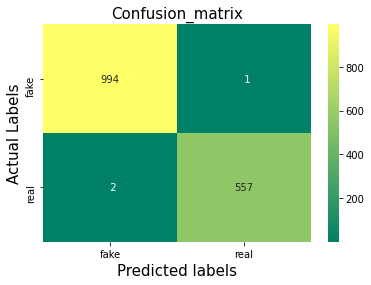

In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

classes =list(le.classes_)
sns.heatmap(confusion_matrix(y_test, y_hat),annot=True, fmt='3.0f', cmap="summer", xticklabels=classes, yticklabels=classes)
plt.title('Confusion_matrix', y=1.05, size=15)
plt.ylabel('Actual Labels', y=0.5, size=15)
plt.xlabel('Predicted labels', y=1.05, size=15)

## test

In [0]:
test_img_features = extract_image_features(['face-only-dataset/real/nuaa/0001/0001_00_00_01_0.jpg'])
clf.predict(test_img_features)

array([1])

## Save

### Label encoder

In [0]:
np.save('classes.npy', le.classes_)

### save classifier

In [0]:
from joblib import dump

dump(clf, 'classifier.joblib') 

['classifier.joblib']

## Test loading

### Load label encoder

In [0]:
from sklearn import preprocessing
import numpy as np

le = preprocessing.LabelEncoder()
le.classes_ = np.load('classes.npy')

### classifier

In [0]:
from joblib import load

clf = load('classifier.joblib') 

## Testing

In [0]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 8.5MB/s 


In [0]:
# demonstrate face detection on 5 Celebrity Faces Dataset
from os import listdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN
 
# extract a single face from a given photograph
def extract_face(filename, required_size=(240, 240)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

In [0]:
from PIL import Image

face_array = extract_face("face-only-dataset/fake/nuaa/0001/0001_00_00_01_0.jpg")
im = Image.fromarray(face_array)
output_face_filename = "face.jpeg"
im.save(output_face_filename)

test_img_features = extract_image_features([output_face_filename])
pred = clf.predict(test_img_features)

prediction = list(le.inverse_transform(pred))[0]
print(prediction)

fake


## Webcanm testing

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [0]:
from IPython.display import Image
from PIL import Image

try:
    filename = take_photo()
    print('Saved to {}'.format(filename))

    test_img_features = extract_image_features([filename])
    result = clf.predict(test_img_features)
    print(result)
    print(list(le.inverse_transform(result)))

    # # Show the image which was just taken.
    # display(Image(filename))

except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

<IPython.core.display.Javascript object>

Saved to photo.jpg
[1]
['real']


In [0]:
print(list(le.inverse_transform([0, 1, 1])))

['fake', 'real', 'real']


## Complete image testing

In [0]:
test_img_features = extract_image_features(['photo.jpg'])
pred = clf.predict(test_img_features)

prediction = list(le.inverse_transform(pred))[0]
print(prediction)

real
